In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re


In [ ]:
# short preprocess
dataset_dir = 'mimic-4/physionet.org/files/mimiciv/3.1/'
df = pd.read_csv(os.path.join(dataset_dir, "hosp/diagnoses_icd.csv"))
admissions = pd.read_csv(os.path.join(dataset_dir, "hosp/admissions.csv"))
df = pd.merge(
    df,
    admissions[['hadm_id', 'admittime', 'dischtime', 'deathtime']],
    on='hadm_id'
)

#  ICD-9 -> ICD-10
df["icd_code"] = ( 
    df["icd_code"]
      .astype(str)
      .str.replace(r"\s+", "", regex=True)
      .str.upper()
)
gem_9to10 = (
    pd.read_csv("2015_I9gem.txt", dtype=str, names=["icd9", "icd10", "flag"])
      .drop(columns="flag")
      .drop_duplicates()
)

map9 = gem_9to10.groupby("icd9")["icd10"].first().to_dict()

def to_icd10(code: str, version: int) -> str | None:
    if version == 10:
        return code
    return map9.get(code)

df["icd10_code"] = df.apply(
    lambda r: to_icd10(r.icd_code, r.icd_version), axis=1
)
print(df["icd10_code"].nunique())
df = df.dropna(subset=["icd10_code"])  # если есть кто не маппится

print(df["icd10_code"].nunique())

def is_onco(code: str) -> int:
    """
    Malignant neoplasms  C00–C97
    In-situ + uncertain   D00–D09, D37–D48
    Берём три ведущих символа и проверяем диапазоны.
    """
    c = code.upper()
    if c[0] == "C":
        return 1
    if re.match(r"D0[0-9]|D[3-4][7-8]", c):
        return 1
    return 0

df["is_oncology"] = df["icd10_code"].map(is_onco).astype("int8")
df["category"] = df["icd10_code"].str[:3]

# df.to_csv('../prepared_data.csv')
df.head(5)

In [2]:
df = pd.read_csv("../prepared_data.csv")  
df.head()

,Unnamed: 0,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,deathtime,icd10_code,is_oncology,category
0,40,10000084,23052089,1,G3183,10,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,G3183,0,G31
1,41,10000084,23052089,2,F0280,10,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,F0280,0,F02
2,42,10000084,23052089,3,R441,10,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,R441,0,R44
3,43,10000084,23052089,4,R296,10,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,R296,0,R29
4,44,10000084,23052089,5,E785,10,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,E785,0,E78


In [ ]:
# чистим, где один и тот же диагноз в одной госп-ии
df_unique = df[['subject_id', 'icd10_code']].drop_duplicates()

unique_icds = df_unique['icd10_code'].dropna().unique()
icd2idx = {icd: i for i, icd in enumerate(unique_icds)}
idx2icd = {i: icd for icd, i in icd2idx.items()}
n = len(unique_icds)

# сколько пациентов имели одновременно оба кода
co_occurrence = np.zeros((n, n), dtype=int)


for subject_id, group in df_unique.groupby('subject_id'):
    codes = group['icd10_code'].unique()
    indices = [icd2idx[code] for code in codes if code in icd2idx]
    for i in indices:
        for j in indices:
            co_occurrence[i, j] += 1

total_patients = df['subject_id'].nunique()

# доля пациентов с обоими диагнозами от общего числа пациентов
co_occurrence_fraction = co_occurrence / total_patients

# условная вероятность 
patients_per_code = co_occurrence.diagonal().copy()
patients_per_code[patients_per_code == 0] = 1  # чтобы не делить на 0
conditional_prob = co_occurrence / patients_per_code[:, None]

co_df = pd.DataFrame(co_occurrence, index=unique_icds, columns=unique_icds)
fraction_df = pd.DataFrame(co_occurrence_fraction, index=unique_icds, columns=unique_icds)
cond_df = pd.DataFrame(conditional_prob, index=unique_icds, columns=unique_icds)

co_df.to_csv("data/co_matrix_counts.csv") # сколько уникальных пациентов имели одновременно диагнозы i и j
fraction_df.to_csv("data/co_matrix_fraction.csv") # доля пациентов из всей выборки у которых одновременно были диагнозы i и j
cond_df.to_csv("data/co_matrix_conditional_prob.csv") # усл вероятность

In [2]:
co_df = pd.read_csv("data/co_matrix_counts.csv")
fraction_df = pd.read_csv("data/co_matrix_fraction.csv") 
cond_df = pd.read_csv("data/co_matrix_conditional_prob.csv")

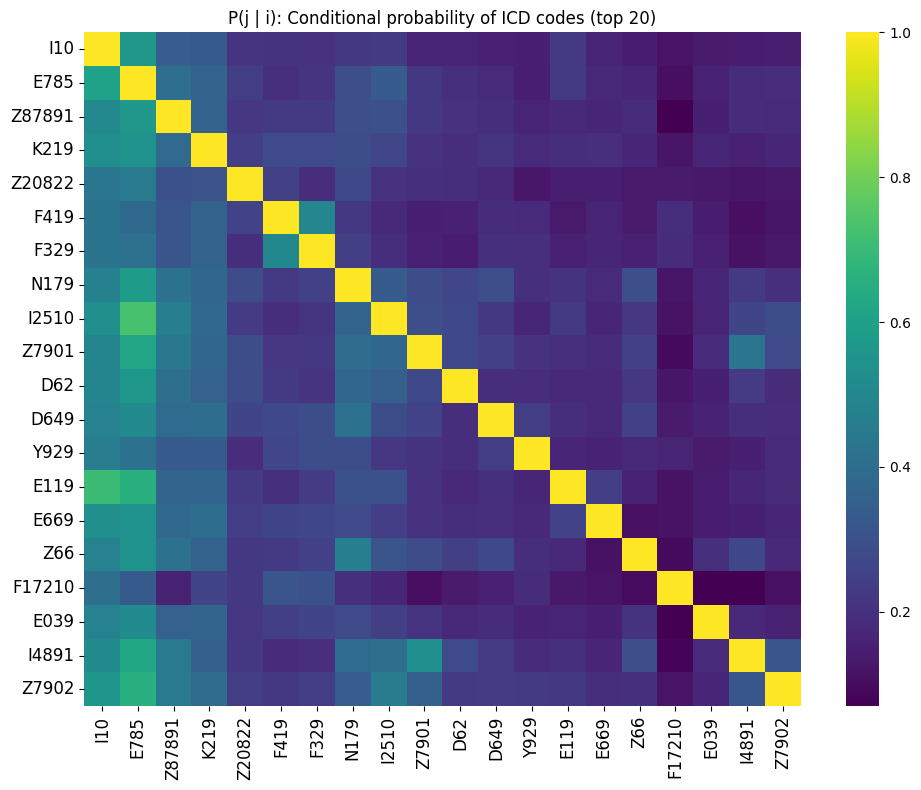

In [ ]:
N = 20
diag_values = np.diag(fraction_df)
top_20_indices = np.argsort(diag_values)[::-1][:N]
top_icds = [idx2icd[i] for i in top_20_indices]


top_cond_df = cond_df.loc[top_icds, top_icds]

plt.figure(figsize=(10, 8))
sns.heatmap(top_cond_df, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Co-occurance probability of ICD codes (top 20)")
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


TBA

In [1]:
# по самым частым сочетаниям диагнозов (абсолютное количество)
co_long = co_df.stack().reset_index()
co_long.columns = ['icd_i', 'icd_j', 'count']

# убираем дубли по диагонали
co_long = co_long[co_long['icd_i'] != co_long['icd_j']]

# фильтруем явно некорректные строки и приводим к числу
co_long = co_long[pd.to_numeric(co_long['count'], errors='coerce').notnull()]
co_long['count'] = co_long['count'].astype(int)

# сортируем
top20_co = co_long.sort_values('count', ascending=False).head(20)



NameError: name 'co_df' is not defined

In [ ]:
# по условной вероятности 
cond_long = cond_df.stack().reset_index()
cond_long.columns = ['icd_i', 'icd_j', 'p_j_given_i']
cond_long = cond_long[cond_long['icd_i'] != cond_long['icd_j']]
top20_cond = cond_long.sort_values('p_j_given_i', ascending=False).head(20)

In [ ]:
top20_co.to_csv("data/top20_co.csv")
top20_cond.to_csv("data/top20_cond.csv")

In [ ]:
def plot_heatmap(dataframe, value_col, title):
    pivot = dataframe.pivot(index='icd_i', columns='icd_j', values=value_col)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_heatmap(top20_co, 'count', 'Top 20 Co-occurrence Counts (Patients with both ICDs)')

plot_heatmap(top20_cond, 'p_j_given_i', 'Top 20 Conditional Probabilities P(j | i)')

